tgb - 6/13/2021 - The panel should include:  
-  The influence of progressive rescalings on the Tropical MSE  
-  The training curves indicating overall performance as a function of epoch    
-  Lat/lon maps of performance for both BF/CI networks    
-  PDFs of output prediction for pre/post processing

# Imports

In [1]:
import sys
sys.path.insert(1,"/home1/07064/tg863631/anaconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages") #work around for h5py
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
from cbrain.climate_invariant import *

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from tensorflow import math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_probability as tfp
import xarray as xr
import numpy as np

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
import matplotlib.ticker as mticker
import matplotlib.transforms as mtrans
import matplotlib.pylab as plb
# from mpl_toolkits.basemap import Basemap
# bm = Basemap()

import pickle
# from climate_invariant import *
from tensorflow.keras import layers
import datetime
from climate_invariant_utils import *
import yaml


/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


In [84]:
fz = 15
lw = 4
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

## Global Variables

In [2]:
# Load coordinates (just pick any file from the climate model run)

# GP path below
path_0K = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/fluxbypass_aqua/'
coor = xr.open_dataset(path_0K+"AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-09-02-00000.nc")

lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [3]:
path_folRG = '/DFS-L/DATA/pritchard/liranp/'
path_RG0K = path_folRG + 'SST_0001Kp_Neuralnet_SPCAM_all_216/atm/hist/SST_0001Kp_Neuralnet_SPCAM_all_216.cam.h1.2013-'
path_RG0K = path_RG0K + '05-05-*.nc'

coor_RG = xr.open_mfdataset(path_RG0K,decode_cf=False)
latRG = coor_RG.lat; lonRG = coor_RG.lon; levRG = coor_RG.lev;
coor_RG.close();

/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from

In [4]:
# GP path below
TRAINDIR = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path = '/export/nfs0home/tbeucler/CBRAIN-CAM/cbrain/'
path_nnconfig = '/export/nfs0home/tbeucler/CBRAIN-CAM/nn_config/'

# Load hyam and hybm to calculate pressure field in SPCAM
path_hyam = 'hyam_hybm.pkl'
hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)

# Scale dictionary to convert the loss to W/m2
scale_dict = load_pickle(path_nnconfig+'scale_dicts/009_Wm2_scaling.pkl')

New Data generator class for the climate-invariant network. Calculates the physical rescalings needed to make the NN climate-invariant

## Data Generators

### Choose between aquaplanet and realistic geography here

In [5]:
# GP paths below
#path_aquaplanet = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
#path_realgeography = ''

# GP /fast paths below
path_aquaplanet = '/fast/tbeucler/climate_invariant/aquaplanet/'

# Comet paths below
# path_aquaplanet = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'
# path_realgeography = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/geography/'

path = path_aquaplanet

### Data Generator using RH

In [6]:
#scale_dict_RH = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling_2.pkl')
scale_dict_RH = scale_dict.copy()
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%

in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
# if path==path_realgeography: out_vars_RH = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']
# elif path==path_aquaplanet: out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
if path==path_aquaplanet: out_vars_RH = ['PHQ','TPHYSTND','QRL','QRS']

# New GP path below
TRAINFILE_RH = '2021_01_24_O3_small_shuffle.nc'
NORMFILE_RH = '2021_02_01_NORM_O3_RH_small.nc'
    
# Comet/Ankitesh path below
# TRAINFILE_RH = 'CI_RH_M4K_NORM_train_shuffle.nc'
# NORMFILE_RH = 'CI_RH_M4K_NORM_norm.nc'
# VALIDFILE_RH = 'CI_RH_M4K_NORM_valid.nc'

In [7]:
train_gen_RH = DataGenerator(
    data_fn = path+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = path+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using QSATdeficit

We only need the norm file for this generator as we are solely using it as an input to determine the right normalization for the combined generator

In [8]:
# New GP path below
TRAINFILE_QSATdeficit = '2021_02_01_O3_QSATdeficit_small_shuffle.nc'
NORMFILE_QSATdeficit = '2021_02_01_NORM_O3_QSATdeficit_small.nc'

In [9]:
in_vars_QSATdeficit = ['QSATdeficit','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
# if path==path_realgeography: out_vars_RH = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']
# elif path==path_aquaplanet: out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
if path==path_aquaplanet: out_vars_QSATdeficit = ['PHQ','TPHYSTND','QRL','QRS']

In [10]:
train_gen_QSATdeficit = DataGenerator(
    data_fn = path+TRAINFILE_QSATdeficit,
    input_vars = in_vars_QSATdeficit,
    output_vars = out_vars_QSATdeficit,
    norm_fn = path+NORMFILE_QSATdeficit,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using TNS

In [11]:
in_vars = ['QBP','TfromNS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_TNS = '2021_02_01_O3_TfromNS_small_shuffle.nc'
NORMFILE_TNS = '2021_02_01_NORM_O3_TfromNS_small.nc'
VALIDFILE_TNS = 'CI_TNS_M4K_NORM_valid.nc'

In [12]:
train_gen_TNS = DataGenerator(
    data_fn = path+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using BCONS

In [13]:
in_vars = ['QBP','BCONS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_BCONS = '2021_02_01_O3_BCONS_small_shuffle.nc'
NORMFILE_BCONS = '2021_02_01_NORM_O3_BCONS_small.nc'

In [14]:
train_gen_BCONS = DataGenerator(
    data_fn = path+TRAINFILE_BCONS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_BCONS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using BMSE

In [15]:
in_vars = ['QBP','BMSE','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_BMSE = '2021_06_16_BMSE_small_shuffle.nc'
NORMFILE_BMSE = '2021_06_16_NORM_BMSE_small.nc'

In [16]:
train_gen_BMSE = DataGenerator(
    data_fn = path+TRAINFILE_BMSE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_BMSE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using NSto220

In [17]:
in_vars = ['QBP','T_NSto220','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_T_NSto220 = '2021_03_31_O3_T_NSto220_small.nc'
NORMFILE_T_NSto220 = '2021_03_31_NORM_O3_T_NSto220_small.nc'

In [18]:
train_gen_T_NSto220 = DataGenerator(
    data_fn = path+TRAINFILE_T_NSto220,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_T_NSto220,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=8192,
    shuffle=True,
)

### Data Generator using LHF_nsDELQ

In [19]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHF_nsDELQ']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_LHF_nsDELQ = '2021_02_01_O3_LHF_nsDELQ_small_shuffle.nc'
NORMFILE_LHF_nsDELQ = '2021_02_01_NORM_O3_LHF_nsDELQ_small.nc'

In [20]:
train_gen_LHF_nsDELQ = DataGenerator(
    data_fn = path+TRAINFILE_LHF_nsDELQ,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_LHF_nsDELQ,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=8192,
    shuffle=True,
)

### Data Generator using LHF_nsQ

In [21]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHF_nsQ']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_LHF_nsQ = '2021_02_01_O3_LHF_nsQ_small_shuffle.nc'
NORMFILE_LHF_nsQ = '2021_02_01_NORM_O3_LHF_nsQ_small.nc'

In [22]:
train_gen_LHF_nsQ = DataGenerator(
    data_fn = path+TRAINFILE_LHF_nsQ,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_LHF_nsQ,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=8192,
    shuffle=True,
)

### Data Generator Combined (latest flexible version)

In [23]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
#if path==path_aquaplanet: out_vars=['PHQPERC','TPHYSTNDPERC','QRLPERC','QRSPERC']
out_vars = ['PHQ','TPHYSTND','QRL','QRS']

In [24]:
# TRAINFILE = '2021_01_24_O3_TRAIN_shuffle.nc'
NORMFILE = '2021_01_24_NORM_O3_small.nc'
# VALIDFILE = '2021_01_24_O3_VALID.nc'
# GENTESTFILE = 'CI_SP_P4K_valid.nc'

# In physical space
TRAINFILE = '2021_03_18_O3_TRAIN_M4K_shuffle.nc'
VALIDFILE = '2021_03_18_O3_VALID_M4K.nc'
TESTFILE_DIFFCLIMATE = '2021_03_18_O3_TRAIN_P4K_shuffle.nc'
TESTFILE_DIFFGEOG = '2021_04_18_RG_TRAIN_M4K_shuffle.nc'

# In percentile space
#TRAINFILE = '2021_04_09_PERC_TRAIN_M4K_shuffle.nc'
#TRAINFILE = '2021_01_24_O3_small_shuffle.nc'
#VALIDFILE = '2021_04_09_PERC_VALID_M4K.nc'
#TESTFILE = '2021_04_09_PERC_TEST_P4K.nc'

Old data generator by Ankitesh

Improved flexible data generator

In [25]:
train_gen_CI = DataGeneratorCI(data_fn = path+TRAINFILE,
                               input_vars=in_vars,
                               output_vars=out_vars,
                               norm_fn=path+NORMFILE,
                               input_transform=('mean', 'maxrs'),
                               output_transform=scale_dict,
                               batch_size=8192,
                               shuffle=True,
                               xarray=False,
                               var_cut_off=None, 
                               Qscaling=None,
                               Tscaling=None,
                               LHFscaling=None,
                               SHFscaling=None,
                               output_scaling=False,
                               interpolate=False,
                               hyam=hyam,hybm=hybm,
                               inp_sub_Qscaling=None,
                               inp_div_Qscaling=None,
                               inp_sub_Tscaling=None,
                               inp_div_Tscaling=None,
                               inp_sub_LHFscaling=None,
                               inp_div_LHFscaling=None,
                               inp_sub_SHFscaling=None,
                               inp_div_SHFscaling=None,
                               lev=None, interm_size=40,
                               lower_lim=6,is_continous=True,Tnot=5,
                               epsQ=1e-3,epsT=1,mode='train')

In [26]:
valid_gen_CI = DataGeneratorCI(data_fn = path+VALIDFILE,
                               input_vars=in_vars,
                               output_vars=out_vars,
                               norm_fn=path+NORMFILE,
                               input_transform=('mean', 'maxrs'),
                               output_transform=scale_dict,
                               batch_size=8192,
                               shuffle=True,
                               xarray=False,
                               var_cut_off=None, 
                               Qscaling=None,
                               Tscaling=None,
                               LHFscaling=None,
                               SHFscaling=None,
                               output_scaling=False,
                               interpolate=False,
                               hyam=hyam,hybm=hybm,
                               inp_sub_Qscaling=None,
                               inp_div_Qscaling=None,
                               inp_sub_Tscaling=None,
                               inp_div_Tscaling=None,
                               inp_sub_LHFscaling=None,
                               inp_div_LHFscaling=None,
                               inp_sub_SHFscaling=None,
                               inp_div_SHFscaling=None,
                               lev=None, interm_size=40,
                               lower_lim=6,is_continous=True,Tnot=5,
                               epsQ=1e-3,epsT=1,mode='train')

In [27]:
test_diffclimate_gen_CI = DataGeneratorCI(data_fn = path+TESTFILE_DIFFCLIMATE,
                                       input_vars=in_vars,
                                       output_vars=out_vars,
                                       norm_fn=path+NORMFILE,
                                       input_transform=('mean', 'maxrs'),
                                       output_transform=scale_dict,
                                       batch_size=8192,
                                       shuffle=True,
                                       xarray=False,
                                       var_cut_off=None, 
                                       Qscaling=None,
                                       Tscaling=None,
                                       LHFscaling=None,
                                       SHFscaling=None,
                                       output_scaling=False,
                                       interpolate=False,
                                       hyam=hyam,hybm=hybm,
                                       inp_sub_Qscaling=None,
                                       inp_div_Qscaling=None,
                                       inp_sub_Tscaling=None,
                                       inp_div_Tscaling=None,
                                       inp_sub_LHFscaling=None,
                                       inp_div_LHFscaling=None,
                                       inp_sub_SHFscaling=None,
                                       inp_div_SHFscaling=None,
                                       lev=None, interm_size=40,
                                       lower_lim=6,is_continous=True,Tnot=5,
                                       epsQ=1e-3,epsT=1,mode='train')

In [28]:
test_diffgeog_gen_CI = DataGeneratorCI(data_fn = path+TESTFILE_DIFFGEOG,
                                       input_vars=in_vars,
                                       output_vars=out_vars,
                                       norm_fn=path+NORMFILE,
                                       input_transform=('mean', 'maxrs'),
                                       output_transform=scale_dict,
                                       batch_size=8192,
                                       shuffle=True,
                                       xarray=False,
                                       var_cut_off=None, 
                                       Qscaling=None,
                                       Tscaling=None,
                                       LHFscaling=None,
                                       SHFscaling=None,
                                       output_scaling=False,
                                       interpolate=False,
                                       hyam=hyam,hybm=hybm,
                                       inp_sub_Qscaling=None,
                                       inp_div_Qscaling=None,
                                       inp_sub_Tscaling=None,
                                       inp_div_Tscaling=None,
                                       inp_sub_LHFscaling=None,
                                       inp_div_LHFscaling=None,
                                       inp_sub_SHFscaling=None,
                                       inp_div_SHFscaling=None,
                                       lev=None, interm_size=40,
                                       lower_lim=6,is_continous=True,Tnot=5,
                                       epsQ=1e-3,epsT=1,mode='train')

## Load Aquaplanet Coordinates

In [29]:
path_folder = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/'

In [30]:
pathAQ_m4K = path_folder + 'sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.00'
pathAQ_0K = path_folder + 'fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.00'
pathAQ_p4K = path_folder + 'sp8fbp_4k/sp8fbp_4k.cam2.h2.00'

In [31]:
STaqua_m4K = xr.open_dataset(pathAQ_m4K+'00-03-01-00000.nc')

In [32]:
STaqua_0K = xr.open_dataset(pathAQ_0K+'00-03-01-00000.nc')

In [33]:
STaqua_p4K = xr.open_dataset(pathAQ_p4K+'00-03-01-00000.nc')

## Load Real-geography Coordinates

In [34]:
path_folRG = '/DFS-L/DATA/pritchard/liranp/'

In [35]:
path_m4K = path_folRG + 'SST_4Km_Neuralnet_SPCAM_all_small_216/atm/hist/SST_4Km_Neuralnet_SPCAM_all_small_216.cam.h1.2009-'
path_0K = path_folRG + 'SST_0001Kp_Neuralnet_SPCAM_all_216/atm/hist/SST_0001Kp_Neuralnet_SPCAM_all_216.cam.h1.2013-'
path_p4K = path_folRG + 'SST_4Kp_Neuralnet_SPCAM_all_v2_216/atm/hist/SST_4Kp_Neuralnet_SPCAM_all_v2_216.cam.h1.2009-'

In [36]:
ST_m4K = xr.open_dataset(path_m4K+'01-01-00000.nc',decode_cf=False)

In [37]:
ST_0K = xr.open_dataset(path_0K+'01-01-00000.nc',decode_cf=False)

In [38]:
ST_p4K = xr.open_dataset(path_p4K+'01-01-00000.nc',decode_cf=False)

# First row: Progressive improvement in Tropical MSE in aquaplanet

## Load models and generators

In [265]:
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'

In [266]:
# Model's path
# path_array = ['2021_02_01_MLR.hdf5','2021_02_01_MLR_RH.hdf5',
#               '2021_03_19_MLR_RH_BCONS.hdf5','2021_03_23_MLR_RH_BCONS_LHF_nsDELQ.hdf5',
#              '2021_04_27_W2C_MLR.hdf5',
#               '2021_04_26_NN.hdf5','2021_04_26_NN_RH_BCONS_LHF_nsDELQ.hdf5',
#               '2021_04_27_W2C_NN.hdf5']
# path_array = [
#     '2021_04_26_NN.hdf5','2021_06_13_NN_RH.hdf5',
#     '2021_06_13_NN_RH_BCONS.hdf5',
#     '2021_04_26_NN_RH_BCONS_LHF_nsDELQ.hdf5',
#     '2021_04_26_NN_RH_TfromNS_LHF_nsDELQ.hdf5',
#     '2021_04_27_W2C_NN.hdf5',
#     '2021_02_01_MLR.hdf5','2021_03_23_MLR_RH_BCONS_LHF_nsDELQ.hdf5',
#     '2021_04_27_W2C_MLR.hdf5'
# ]
path_array = [
    '2021_04_26_NN.hdf5','2021_06_13_NN_RH.hdf5',
    '2021_06_21_NN_RH_BMSE.hdf5',
    '2021_06_17_NN_RH_BMSE_LHF_nsDELQ.hdf5',
    '2021_04_26_NN_RH_TfromNS_LHF_nsDELQ.hdf5',
    '2021_04_27_W2C_NN.hdf5',
    '2021_02_01_MLR.hdf5',
    '2021_06_17_MLR_RH_BMSE_LHF_nsDELQ.hdf5',
    '2021_04_27_W2C_MLR.hdf5'
]

In [267]:
MODEL = {}

In [268]:
for ipath,path in enumerate(path_array):
    print('path=',path)
    MODEL[path] = load_model(path_HDF5+path,compile=False)

path= 2021_04_26_NN.hdf5
path= 2021_06_13_NN_RH.hdf5
path= 2021_06_21_NN_RH_BMSE.hdf5
path= 2021_06_17_NN_RH_BMSE_LHF_nsDELQ.hdf5
path= 2021_04_26_NN_RH_TfromNS_LHF_nsDELQ.hdf5
path= 2021_04_27_W2C_NN.hdf5
path= 2021_02_01_MLR.hdf5
path= 2021_06_17_MLR_RH_BMSE_LHF_nsDELQ.hdf5
path= 2021_04_27_W2C_MLR.hdf5


In [269]:
TRAINFILE = '2021_03_18_O3_VALID_M4K.nc'
TESTFILE_DIFFCLIMATE = '2021_03_18_O3_VALID_P4K.nc'

In [270]:
Qscaling_array = [None,'RH','RH','RH','RH',None,None,'RH',None]
Tscaling_array = [None,None,'BMSE','BMSE','TfromNS',None,None,'BMSE',None]
LHFscaling_array = [None,None,None,'LHF_nsDELQ','LHF_nsDELQ',None,None,'LHF_nsDELQ',None]

In [271]:
inp_sub_Qarray = [None,train_gen_RH.input_transform.sub,train_gen_RH.input_transform.sub,
                  train_gen_RH.input_transform.sub,train_gen_RH.input_transform.sub,None,
                 None,train_gen_RH.input_transform.sub,None]
inp_div_Qarray = [None,train_gen_RH.input_transform.div,train_gen_RH.input_transform.div,
                  train_gen_RH.input_transform.div,train_gen_RH.input_transform.div,None,
                 None,train_gen_RH.input_transform.div,None]
inp_sub_Tarray = [None,None,train_gen_BMSE.input_transform.sub,train_gen_BMSE.input_transform.sub,
                  train_gen_TNS.input_transform.sub,None,
                 None,train_gen_BMSE.input_transform.sub,None]
inp_div_Tarray = [None,None,train_gen_BMSE.input_transform.div,train_gen_BMSE.input_transform.div,
                  train_gen_TNS.input_transform.div,None,
                 None,train_gen_BMSE.input_transform.div,None]
inp_sub_LHFarray = [None,None,None,train_gen_LHF_nsDELQ.input_transform.sub,
                    train_gen_LHF_nsDELQ.input_transform.sub,None,
                   None,train_gen_LHF_nsDELQ.input_transform.sub,None]
inp_div_LHFarray = [None,None,None,train_gen_LHF_nsDELQ.input_transform.div,
                    train_gen_LHF_nsDELQ.input_transform.div,None,
                   None,train_gen_LHF_nsDELQ.input_transform.div,None]

In [272]:
train_m4K = {}
train_p4K = {}

In [273]:
path_data = path_aquaplanet

In [274]:
for ipath,path in enumerate(path_array):
    train_m4K[path] = DataGeneratorCI(data_fn = path_data+TRAINFILE,
                                      input_vars=in_vars,
                                      output_vars=out_vars,
                                      norm_fn=path_data+NORMFILE,
                                      input_transform=('mean', 'maxrs'),
                                      output_transform=scale_dict,
                                      batch_size=8192,
                                      shuffle=True,
                                      xarray=False,
                                      var_cut_off=None,
                                      Qscaling=Qscaling_array[ipath],
                                      Tscaling=Tscaling_array[ipath],
                                      LHFscaling=LHFscaling_array[ipath],
                                      SHFscaling=None,
                                      output_scaling=False,
                                      interpolate=False,
                                      hyam=hyam,hybm=hybm,
                                      inp_sub_Qscaling=inp_sub_Qarray[ipath],
                                      inp_div_Qscaling=inp_div_Qarray[ipath],
                                      inp_sub_Tscaling=inp_sub_Tarray[ipath],
                                      inp_div_Tscaling=inp_div_Tarray[ipath],
                                      inp_sub_LHFscaling=inp_sub_LHFarray[ipath],
                                      inp_div_LHFscaling=inp_div_LHFarray[ipath],
                                      inp_sub_SHFscaling=None,
                                      inp_div_SHFscaling=None,
                                      lev=None, interm_size=40,
                                      lower_lim=6,is_continous=True,Tnot=5,
                                      epsQ=1e-3,epsT=1,mode='train')
    train_p4K[path] = DataGeneratorCI(data_fn = path_data+TESTFILE_DIFFCLIMATE,
                                      input_vars=in_vars,
                                      output_vars=out_vars,
                                      norm_fn=path_data+NORMFILE,
                                      input_transform=('mean', 'maxrs'),
                                      output_transform=scale_dict,
                                      batch_size=8192,
                                      shuffle=True,
                                      xarray=False,
                                      var_cut_off=None,
                                      Qscaling=Qscaling_array[ipath],
                                      Tscaling=Tscaling_array[ipath],
                                      LHFscaling=LHFscaling_array[ipath],
                                      SHFscaling=None,
                                      output_scaling=False,
                                      interpolate=False,
                                      hyam=hyam,hybm=hybm,
                                      inp_sub_Qscaling=inp_sub_Qarray[ipath],
                                      inp_div_Qscaling=inp_div_Qarray[ipath],
                                      inp_sub_Tscaling=inp_sub_Tarray[ipath],
                                      inp_div_Tscaling=inp_div_Tarray[ipath],
                                      inp_sub_LHFscaling=inp_sub_LHFarray[ipath],
                                      inp_div_LHFscaling=inp_div_LHFarray[ipath],
                                      inp_sub_SHFscaling=None,
                                      inp_div_SHFscaling=None,
                                      lev=None, interm_size=40,
                                      lower_lim=6,is_continous=True,Tnot=5,
                                      epsQ=1e-3,epsT=1,mode='train')

## Calculate MSE as a function of lev for out-of-sample TS

In [190]:
lat_ind = np.arange(26,40)
Nbatches = 100
b_random = np.random.choice(np.linspace(0,5700,5701),size=((Nbatches,)),replace=False).astype('int')

In [191]:
MSE = {}
MSE_gen = {}
INP = {}
VAR = {}

In [192]:
for idataset,dataset in enumerate(['AQ-4K','AQ+4K']):
    print('idataset=',idataset,' & dataset=',dataset)
    
    MSE[dataset] = {}; INP[dataset] = {}; VAR[dataset] = {}; MSE_gen[dataset] = {};
    if idataset==0: train_gen_array = train_m4K
    elif idataset==1: train_gen_array = train_p4K
    
    for ipath,path in enumerate(path_array):
        print('path=',path)
            
        model = MODEL[path]
        train_gen = train_gen_array[path]
            
        for ibatch,ib in enumerate(b_random):
            print('ibatch=',ibatch,'/',Nbatches-1,' & ib',ib,end="\r")

            inp = train_gen[ib][0]
            tru = train_gen[ib][1]
            prd = model.predict_on_batch(inp)

            inp_geo = np.reshape(inp,(64,128,inp.shape[1],1))
            prd_geo = np.reshape(prd,(64,128,prd.shape[1]))
            tru_geo = np.reshape(tru,(64,128,tru.shape[1]))

            mse = np.expand_dims(np.mean((tru_geo-prd_geo)**2,axis=2),axis=2)
            var = np.expand_dims(np.var(prd_geo,axis=2),axis=2)
            mse_gen = np.expand_dims(np.mean((tru_geo-prd_geo)[lat_ind,:,:]**2,axis=(0,1)),axis=1)

            if ibatch==0:
                MSE[dataset][path] = mse; 
                VAR[dataset][path] = var; 
                INP[dataset][path] = inp_geo;
                MSE_gen[dataset][path] = mse_gen;
            else:
                MSE[dataset][path] = np.concatenate((MSE[dataset][path],mse),axis=2)
                VAR[dataset][path] = np.concatenate((VAR[dataset][path],var),axis=2)
                INP[dataset][path] = np.concatenate((INP[dataset][path],inp_geo),axis=3)
                MSE_gen[dataset][path] = np.concatenate((MSE_gen[dataset][path],mse_gen),axis=1)

idataset= 0  & dataset= AQ-4K
path= 2021_04_26_NN.hdf5
path= 2021_06_13_NN_RH.hdf5
path= 2021_06_21_NN_RH_BMSE.hdf5
path= 2021_06_17_NN_RH_BMSE_LHF_nsDELQ.hdf5
path= 2021_04_26_NN_RH_TfromNS_LHF_nsDELQ.hdf5
path= 2021_04_27_W2C_NN.hdf5
path= 2021_02_01_MLR.hdf54
path= 2021_06_17_MLR_RH_BMSE_LHF_nsDELQ.hdf5
path= 2021_04_27_W2C_MLR.hdf5
idataset= 1  & dataset= AQ+4K
path= 2021_04_26_NN.hdf5
path= 2021_06_13_NN_RH.hdf5
path= 2021_06_21_NN_RH_BMSE.hdf5
path= 2021_06_17_NN_RH_BMSE_LHF_nsDELQ.hdf5
path= 2021_04_26_NN_RH_TfromNS_LHF_nsDELQ.hdf5
path= 2021_04_27_W2C_NN.hdf5
path= 2021_02_01_MLR.hdf54
path= 2021_06_17_MLR_RH_BMSE_LHF_nsDELQ.hdf5
path= 2021_04_27_W2C_MLR.hdf5


Text(0.5, 1.0, '-4K Climate')

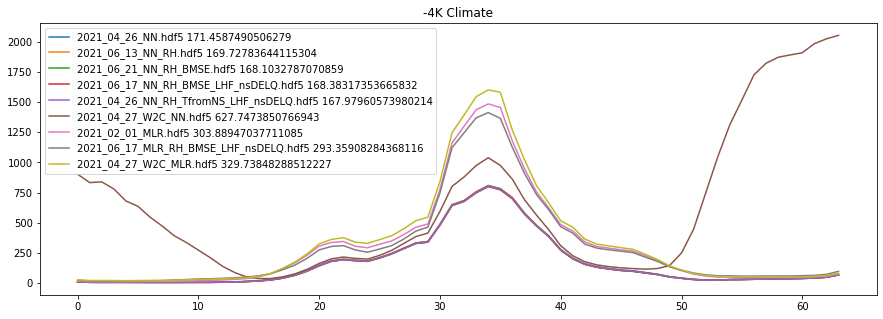

In [193]:
plt.figure(figsize=(15,5))
#for ikey,key in enumerate(['2021_02_01_MLR.hdf5', '2021_02_01_MLR_RH.hdf5', '2021_03_19_MLR_RH_BCONS.hdf5', '2021_03_23_MLR_RH_BCONS_LHF_nsDELQ.hdf5']):
for ikey,key in enumerate(MSE['AQ-4K'].keys()):
    plt.plot(np.mean(MSE['AQ-4K'][key],axis=(1,2)),
             label=key+' '+str(np.mean(MSE['AQ-4K'][key],axis=(0,1,2))))
plt.legend()
plt.title('-4K Climate')
#plt.colorbar()

Text(0.5, 1.0, '+4K Climate')

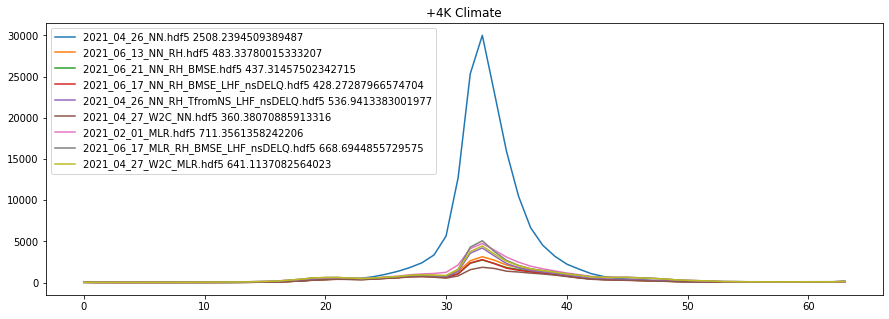

In [194]:
plt.figure(figsize=(15,5))
#for ikey,key in enumerate(['2021_02_01_MLR.hdf5', '2021_02_01_MLR_RH.hdf5', '2021_03_19_MLR_RH_BCONS.hdf5', '2021_03_23_MLR_RH_BCONS_LHF_nsDELQ.hdf5']):
for ikey,key in enumerate(MSE['AQ+4K'].keys()):
    plt.plot(np.mean(MSE['AQ+4K'][key],axis=(1,2)),
             label=key+' '+str(np.mean(MSE['AQ+4K'][key],axis=(0,1,2))))
plt.legend()
plt.title('+4K Climate')
#plt.colorbar()

## Make row figure showing progressive profile improvement

In [43]:
path_array = [
    '2021_04_26_NN.hdf5','2021_06_13_NN_RH.hdf5',
    '2021_06_21_NN_RH_BMSE.hdf5',
    '2021_06_17_NN_RH_BMSE_LHF_nsDELQ.hdf5',
    '2021_04_27_W2C_NN.hdf5',
]

In [44]:
fz = 15
lw = 2
siz = 50
TITa = '(a) MSE in (-4K) Tropics [10$^{3}$ W$^{2}$ m$^{-4}$]'
TITb = '(b) Generalization Test: MSE in (+4K) Tropics [10$^{3}$ W$^{2}$ m$^{-4}$]'
Y0 = 1.1

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

plot_log = [True,True,True]

In [45]:
LAB = ['BF (-4K)','$\\tilde{q}$','$\\tilde{q},\\tilde{T}$',
       '$\\tilde{q},\\tilde{T},\\tilde{\\mathrm{LHF}}}$',
       'BF (+4K)','','','']
XLAB = ['$\\dot{q}$','$\\dot{T}$','$\\dot{q}$','$\\dot{q}$ (Zoom)',
        '$\\dot{T}$','$\\dot{T}$ (Zoom)']
YLAB = 'Pressure [hPa]'

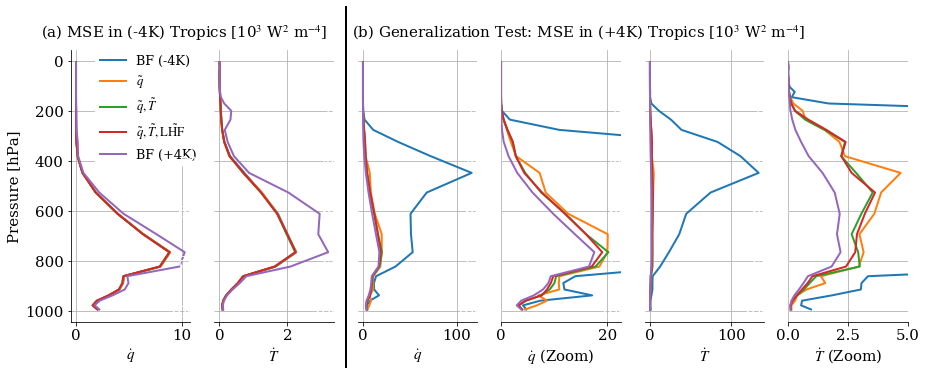

In [46]:
fig, ax = plt.subplots(1,6,figsize=(15,5))

for isub in range(6):
    
    for ipath,path in enumerate(path_array):

        if isub==0: toplot = np.mean(MSE_gen['AQ-4K'][path][:30,:],axis=1)/1e3
        elif isub==1: toplot = np.mean(MSE_gen['AQ-4K'][path][30:60,:],axis=1)/1e3
        elif isub==2 or isub==3: toplot = np.mean(MSE_gen['AQ+4K'][path][:30,:],axis=1)/1e3
        elif isub==4 or isub==5: toplot = np.mean(MSE_gen['AQ+4K'][path][30:60,:],axis=1)/1e3
        
        if isub==0: ax[isub].plot(toplot,coor.lev,label=LAB[ipath])
        else: ax[isub].plot(toplot,coor.lev)

    if isub==0: 
        leg = ax[0].legend(loc='upper right',fontsize=0.85*fz,
                           frameon=True,facecolor='white', framealpha=1,
                           bbox_to_anchor=(1.15,1.025))
        leg.get_frame().set_linewidth(0.0)
    
    ax[isub].invert_yaxis(); ax[isub].grid()
    ax[isub].set_xlabel(XLAB[isub])
    if isub==0: ax[0].set_ylabel(YLAB)

    for ipos,pos in enumerate(['right','top']):
        ax[isub].spines[pos].set_visible(False)
    if isub>0: 
        ax[isub].spines['left'].set_visible(False)
        ax[isub].tick_params(axis='y', colors='white')
    if isub==3: ax[isub].set_xlim((0,22.5))
    elif isub==5: ax[isub].set_xlim((0,5))

plt.draw()
ax[0].text(-0.25,Y0,TITa,va='top',ha ='left',transform = ax[0].transAxes,fontsize=fz);
ax[2].text(2.35,Y0,TITb,va='top',ha ='left',transform = ax[0].transAxes,fontsize=fz);

xs = 0.5*(ax[1].get_position().x1+ax[2].get_position().x0)
line = plt.Line2D([xs,xs],[0,1], transform=fig.transFigure, color="black")
fig.add_artist(line)

In [47]:
LAB = ['BF (-4K)','$\\tilde{q}$','$\\tilde{q},\\tilde{T}$',
       '$\\tilde{q},\\tilde{T},\\tilde{\\mathrm{LHF}}}$',
       'BF (+4K)','','','']
XLAB = ['lw','sw','lw','lw (Zoom)',
        'sw','sw (Zoom)']
YLAB = 'Pressure [hPa]'

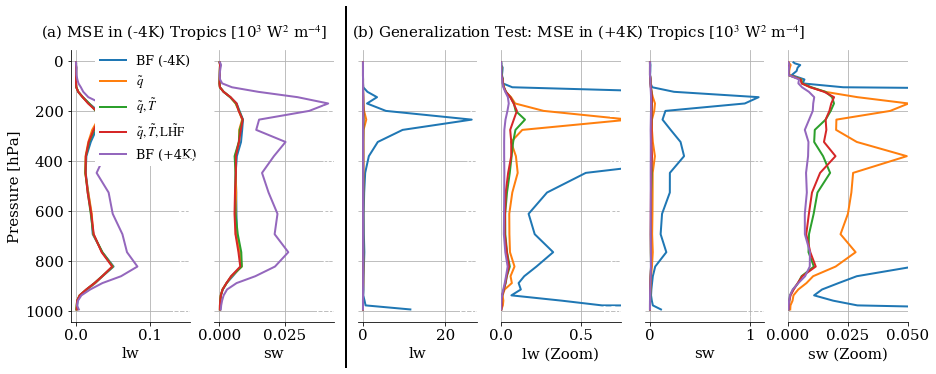

In [48]:
fig, ax = plt.subplots(1,6,figsize=(15,5))

for isub in range(6):
    
    for ipath,path in enumerate(path_array):

        if isub==0: toplot = np.mean(MSE_gen['AQ-4K'][path][60:90,:],axis=1)/1e3
        elif isub==1: toplot = np.mean(MSE_gen['AQ-4K'][path][90:120,:],axis=1)/1e3
        elif isub==2 or isub==3: toplot = np.mean(MSE_gen['AQ+4K'][path][60:90,:],axis=1)/1e3
        elif isub==4 or isub==5: toplot = np.mean(MSE_gen['AQ+4K'][path][90:120,:],axis=1)/1e3
        
        if isub==0: ax[isub].plot(toplot,coor.lev,label=LAB[ipath])
        else: ax[isub].plot(toplot,coor.lev)

    if isub==0: 
        leg = ax[0].legend(loc='upper right',fontsize=0.85*fz,
                           frameon=True,facecolor='white', framealpha=1,
                           bbox_to_anchor=(1.15,1.025))
        leg.get_frame().set_linewidth(0.0)
    
    ax[isub].invert_yaxis(); ax[isub].grid()
    ax[isub].set_xlabel(XLAB[isub])
    if isub==0: ax[0].set_ylabel(YLAB)

    for ipos,pos in enumerate(['right','top']):
        ax[isub].spines[pos].set_visible(False)
    if isub>0: 
        ax[isub].spines['left'].set_visible(False)
        ax[isub].tick_params(axis='y', colors='white')
    if isub==3: ax[isub].set_xlim((0,0.75))
    elif isub==5: ax[isub].set_xlim((0,0.05))

plt.draw()
ax[0].text(-0.25,Y0,TITa,va='top',ha ='left',transform = ax[0].transAxes,fontsize=fz);
ax[2].text(2.35,Y0,TITb,va='top',ha ='left',transform = ax[0].transAxes,fontsize=fz);

xs = 0.5*(ax[1].get_position().x1+ax[2].get_position().x0)
line = plt.Line2D([xs,xs],[0,1], transform=fig.transFigure, color="black")
fig.add_artist(line)

## Combine the two to make a full figure

In [49]:
LAB = ['BF (-4K)','$\\tilde{q}$','$\\tilde{q},\\tilde{T}$',
       '$\\tilde{q},\\tilde{T},\\tilde{\\mathrm{LHF}}}$',
       'BF (+4K)','','','']
XLAB = ['$\\dot{q}$','$\\dot{T}$','$\\dot{q}$','$\\dot{q}$ (Zoom)',
        '$\\dot{T}$','$\\dot{T}$ (Zoom)','lw','sw','lw','lw (Zoom)',
        'sw','sw (Zoom)']
YLAB = 'Pressure [hPa]'

fz = 15
lw = 2
siz = 50
TITa = '(a) MSE in Cold Tropics [10$^{3}$ W$^{2}$ m$^{-4}$]'
TITb = '(b) '+r'$\bf{Generalization}$'+' Test: MSE in Warm Tropics [10$^{3}$ W$^{2}$ m$^{-4}$]'
Y0 = 1.1

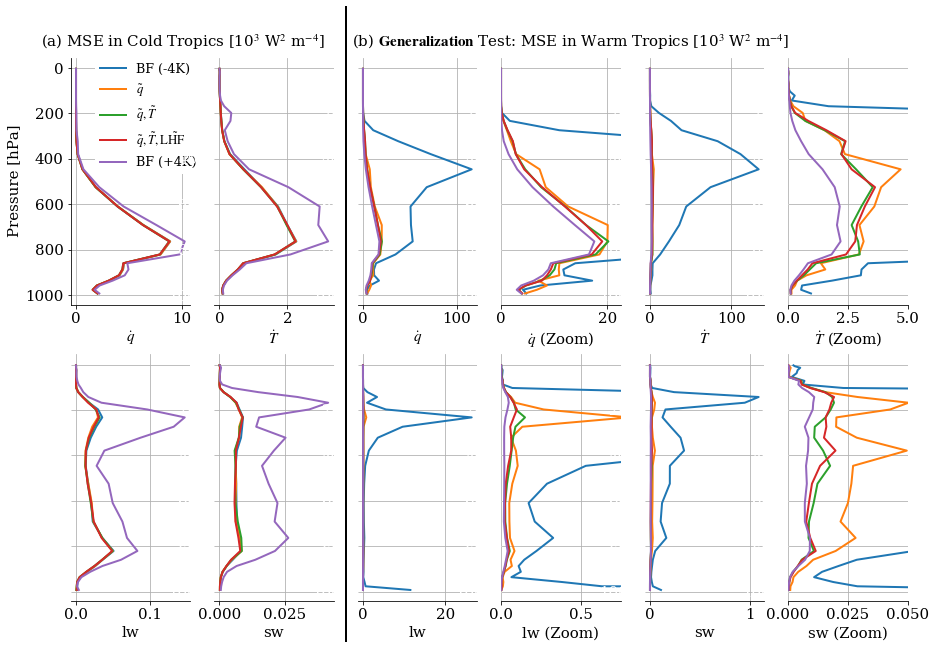

In [50]:
fig, ax = plt.subplots(2,6,figsize=(15,10))

for isub in range(12):
    ilin = int(np.floor(isub/6))
    icol = isub-6*ilin
    for ipath,path in enumerate(path_array):

        if isub==0: toplot = np.mean(MSE_gen['AQ-4K'][path][:30,:],axis=1)/1e3
        elif isub==1: toplot = np.mean(MSE_gen['AQ-4K'][path][30:60,:],axis=1)/1e3
        elif isub==2 or isub==3: toplot = np.mean(MSE_gen['AQ+4K'][path][:30,:],axis=1)/1e3
        elif isub==4 or isub==5: toplot = np.mean(MSE_gen['AQ+4K'][path][30:60,:],axis=1)/1e3
        elif isub==6: toplot = np.mean(MSE_gen['AQ-4K'][path][60:90,:],axis=1)/1e3
        elif isub==7: toplot = np.mean(MSE_gen['AQ-4K'][path][90:120,:],axis=1)/1e3
        elif isub==8 or isub==9: toplot = np.mean(MSE_gen['AQ+4K'][path][60:90,:],axis=1)/1e3
        elif isub==10 or isub==11: toplot = np.mean(MSE_gen['AQ+4K'][path][90:120,:],axis=1)/1e3
        
        if isub==0: ax[ilin,icol].plot(toplot,coor.lev,label=LAB[ipath])
        else: ax[ilin,icol].plot(toplot,coor.lev)

    if isub==0: 
        leg = ax[0,0].legend(loc='upper right',fontsize=0.85*fz,
                           frameon=True,facecolor='white', framealpha=1,
                           bbox_to_anchor=(1.15,1.025))
        leg.get_frame().set_linewidth(0.0)
    
    ax[ilin,icol].invert_yaxis(); ax[ilin,icol].grid()
    ax[ilin,icol].set_xlabel(XLAB[isub])
    if isub==0: ax[0,0].set_ylabel(YLAB)

    for ipos,pos in enumerate(['right','top']):
        ax[ilin,icol].spines[pos].set_visible(False)
    if isub>0: 
        ax[ilin,icol].spines['left'].set_visible(False)
        ax[ilin,icol].tick_params(axis='y', colors='white')
    if isub==3: ax[ilin,icol].set_xlim((0,22.5))
    elif isub==5: ax[ilin,icol].set_xlim((0,5))
    elif isub==9: ax[ilin,icol].set_xlim((0,0.75))
    elif isub==11: ax[ilin,icol].set_xlim((0,0.05))

plt.draw()
ax[0,0].text(-0.25,Y0,TITa,va='top',ha ='left',transform = ax[0,0].transAxes,fontsize=fz);
ax[0,2].text(2.35,Y0,TITb,va='top',ha ='left',transform = ax[0,0].transAxes,fontsize=fz);

xs = 0.5*(ax[0,1].get_position().x1+ax[0,2].get_position().x0)
line = plt.Line2D([xs,xs],[0.07,0.95], transform=fig.transFigure, color="black")
fig.add_artist(line)

# Second row: Training curves

## Load history files

In [51]:
path_PKL = '/export/nfs0home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
epoch = np.arange(1,21)

### Trained on ref climate

In [52]:
path_MLR_BF = path_PKL + 'PKL_DATA2021_04_26_MLR_hist.pkl'
hf = open(path_MLR_BF,'rb')
hist_MLR_BF = pickle.load(hf)
hist_MLR_BF = hist_MLR_BF['hist']

In [53]:
path_NN_BF1 = path_PKL + 'PKL_DATA2021_04_26_NN_hist.pkl'
path_NN_BF2 = path_PKL + 'PKL_DATA2021_05_04_NN_hist.pkl'

hf = open(path_NN_BF1,'rb')
hist_NN_BF1 = pickle.load(hf)
hist_NN_BF1 = hist_NN_BF1['hist']

hf = open(path_NN_BF2,'rb')
hist_NN_BF2 = pickle.load(hf)
hist_NN_BF2 = hist_NN_BF2['hist']

In [54]:
#np.array(hist_NN_BF1[key])+np.array(hist_NN_BF2[key])

In [55]:
hist_NN_BF = {}
for ikey,key in enumerate(hist_NN_BF1.keys()):
    hist_NN_BF[key] = 0.5*(np.array(hist_NN_BF1[key])+np.array(hist_NN_BF2[key]))

In [56]:
path_MLR_BMSE = path_PKL + 'PKL_DATA2021_06_17_MLR_RH_BMSE_LHF_nsDELQ_hist.pkl'
hf = open(path_MLR_BMSE,'rb')
hist_MLR_BMSE = pickle.load(hf)
hist_MLR_BMSE = hist_MLR_BMSE['hist']

In [57]:
path_MLR_TfromNS = path_PKL + 'PKL_DATA2021_04_26_MLR_RH_TfromNS_LHF_nsDELQ_hist.pkl'
hf = open(path_MLR_TfromNS,'rb')
hist_MLR_TfromNS = pickle.load(hf)
hist_MLR_TfromNS = hist_MLR_TfromNS['hist']

In [58]:
path_NN_TfromNS = path_PKL + 'PKL_DATA2021_04_26_NN_RH_TfromNS_LHF_nsDELQ_hist.pkl'
hf = open(path_NN_TfromNS,'rb')
hist_NN_TfromNS = pickle.load(hf)
hist_NN_TfromNS = hist_NN_TfromNS['hist']

In [59]:
path_NN_BMSE = path_PKL + 'PKL_DATA2021_06_17_NN_RH_BMSE_LHF_nsDELQ_hist.pkl'
hf = open(path_NN_BMSE,'rb')
hist_NN_BMSE = pickle.load(hf)
hist_NN_BMSE = hist_NN_BMSE['hist']

In [60]:
# path_NN_BCONS1 = path_PKL + 'PKL_DATA2021_05_05_NN_RH_BCONS_LHF_nsDELQ_hist10.pkl'
# hf = open(path_NN_BCONS1,'rb')
# hist_NN_BCONS1 = pickle.load(hf)
# hist_NN_BCONS1 = hist_NN_BCONS1['hist']

# path_NN_BCONS2 = path_PKL + 'PKL_DATA2021_05_05_NN_RH_BCONS_LHF_nsDELQ_hist20.pkl'
# hf = open(path_NN_BCONS2,'rb')
# hist_NN_BCONS2 = pickle.load(hf)
# hist_NN_BCONS2 = hist_NN_BCONS2['hist']

# hist_NN_BCONS0 = {}
# for key in hist_NN_BCONS1.keys():
#     hist_NN_BCONS0[key] = np.append(hist_NN_BCONS1[key],hist_NN_BCONS2[key])

### Warm to cold

In [61]:
path_MLR_BF_W2C = path_PKL + 'PKL_DATA2021_04_27_W2C_MLR_hist.pkl'
hf = open(path_MLR_BF_W2C,'rb')
hist_MLR_BF_W2C = pickle.load(hf)
hist_MLR_BF_W2C = hist_MLR_BF_W2C['hist']

In [62]:
path_NN_BF_W2C = path_PKL + 'PKL_DATA2021_04_27_W2C_NN_hist.pkl'
hf = open(path_NN_BF_W2C,'rb')
hist_NN_BF_W2C = pickle.load(hf)
hist_NN_BF_W2C = hist_NN_BF_W2C['hist']

In [63]:
path_MLR_BMSE_W2C = path_PKL + 'PKL_DATA2021_04_27_W2C_MLR_RH_BCONS_LHF_nsDELQ_hist.pkl'
hf = open(path_MLR_BMSE_W2C,'rb')
hist_MLR_BMSE_W2C = pickle.load(hf)
hist_MLR_BMSE_W2C = hist_MLR_BMSE_W2C['hist']

In [64]:
path_NN_BMSE_W2C = path_PKL + 'PKL_DATA2021_04_27_W2C_NN_RH_BCONS_LHF_nsDELQ_hist.pkl'
hf = open(path_NN_BMSE_W2C,'rb')
hist_NN_BMSE_W2C = pickle.load(hf)
hist_NN_BMSE_W2C = hist_NN_BMSE_W2C['hist']

In [65]:
path_MLR_TfromNS_W2C = path_PKL + 'PKL_DATA2021_04_27_W2C_MLR_RH_TfromNS_LHF_nsDELQ_hist.pkl'
hf = open(path_MLR_TfromNS_W2C,'rb')
hist_MLR_TfromNS_W2C = pickle.load(hf)
hist_MLR_TfromNS_W2C = hist_MLR_TfromNS_W2C['hist']

In [66]:
path_NN_TfromNS_W2C = path_PKL + 'PKL_DATA2021_04_27_W2C_NN_RH_TfromNS_LHF_nsDELQ_hist.pkl'
hf = open(path_NN_TfromNS_W2C,'rb')
hist_NN_TfromNS_W2C = pickle.load(hf)
hist_NN_TfromNS_W2C = hist_NN_TfromNS_W2C['hist']

### RG to aquaplanet

In [67]:
path_MLR_BF_RG2AQ = path_PKL + 'PKL_DATA2021_06_03_RG2AQ_MLR_hist.pkl'
hf = open(path_MLR_BF_RG2AQ,'rb')
hist_MLR_BF_RG2AQ = pickle.load(hf)
hist_MLR_BF_RG2AQ = hist_MLR_BF_RG2AQ['hist']

In [68]:
path_NN_BF_RG2AQ = path_PKL + 'PKL_DATA2021_06_03_RG2AQ_NN_hist.pkl'
hf = open(path_NN_BF_RG2AQ,'rb')
hist_NN_BF_RG2AQ = pickle.load(hf)
hist_NN_BF_RG2AQ = hist_NN_BF_RG2AQ['hist']

In [69]:
path_MLR_BMSE_RG2AQ = path_PKL + 'PKL_DATA2021_06_17_RG2AQ_MLR_RH_BMSE_LHF_nsDELQ_hist.pkl'
hf = open(path_MLR_BMSE_RG2AQ,'rb')
hist_MLR_BMSE_RG2AQ = pickle.load(hf)
hist_MLR_BMSE_RG2AQ = hist_MLR_BMSE_RG2AQ['hist']

In [70]:
path_NN_BMSE_RG2AQ = path_PKL + 'PKL_DATA2021_06_17_RG2AQ_NN_RH_BMSE_LHF_nsDELQ_hist.pkl'
hf = open(path_NN_BMSE_RG2AQ,'rb')
hist_NN_BMSE_RG2AQ = pickle.load(hf)
hist_NN_BMSE_RG2AQ = hist_NN_BMSE_RG2AQ['hist']

## Make row figure showing transfer learning between cold/warm RG/aquaplanet

In [71]:
X0 = -0.175; # Position of the y labels
Y0 = 1.025; # Position of the text above the subplots

In [72]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

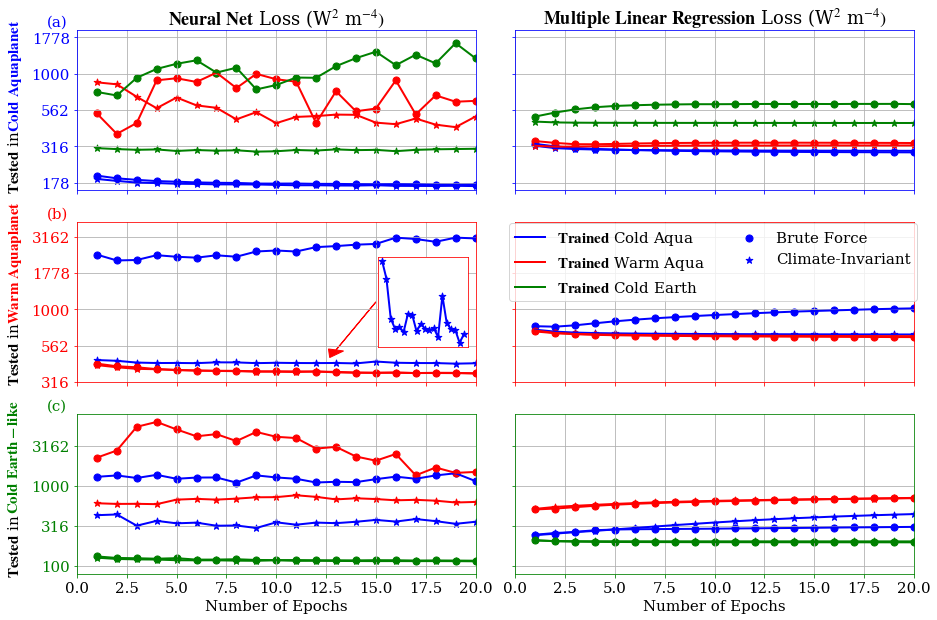

In [73]:
fig, ax = plt.subplots(3,2,figsize=(15,10))
fig.subplots_adjust(hspace=0.2)
fig.subplots_adjust(wspace=0.1)

for isub in range(6):
    ico = int(np.floor(isub/3))
    ili = int(isub-3*np.floor(isub/3))
    
    if ico==1:
        hBF = hist_MLR_BF
        hCI = hist_MLR_BMSE
        hBF_W2C = hist_MLR_BF_W2C
        hCI_W2C = hist_MLR_BMSE_W2C
        hBF_RG2AQ = hist_MLR_BF_RG2AQ
        hCI_RG2AQ = hist_MLR_BMSE_RG2AQ
        LIN = 0; LOG = 1;
    elif ico==0:
        hBF = hist_NN_BF
        hCI = hist_NN_BMSE
        hBF_W2C = hist_NN_BF_W2C
        hCI_W2C = hist_NN_BMSE_W2C
        hBF_RG2AQ = hist_NN_BF_RG2AQ
        hCI_RG2AQ = hist_NN_BMSE_RG2AQ
        LIN = 0; LOG = 1;
    if ili==0:
        k = 'val_loss'
        kW2C = 'trainM4K_loss'
        kRG2AQ = kW2C
    elif ili==1:
        k = 'trainP4K_loss'
        kW2C = 'val_loss'
        kRG2AQ = 'trainP4K_RG_loss'
    elif ili==2:
        k = 'trainM4K_RG_loss'
        kW2C = 'trainP4K_RG_loss'
        kRG2AQ = 'val_loss'
    
    labC = ''; labW = ''; labE = '';labBF = ''; labCI = '';
    if ili==0 and ico==0:
        labC = r"$\bf{Trained}$"+' Cold Aqua'
        labW = r"$\bf{Trained}$"+' Warm Aqua'
        labE = r"$\bf{Trained}$"+' Cold Earth'
        labBF = 'Brute Force'
        labCI = 'Climate-Invariant'
    
    y = np.array(hBF[k])
    ax[ili,ico].scatter(epoch,LIN*y+LOG*np.log10(y),s=siz,color='b',label=labBF)
    ax[ili,ico].plot(epoch,LIN*y+LOG*np.log10(y),color='b',label=labC)

    y = np.array(hCI[k])
    ax[ili,ico].scatter(epoch,LIN*y+LOG*np.log10(y),s=siz,color='b',marker='*',label=labCI)
    ax[ili,ico].plot(epoch,LIN*y+LOG*np.log10(y),color='b')
    
    y = np.array(hBF_W2C[kW2C])
    ax[ili,ico].scatter(epoch,LIN*y+LOG*np.log10(y),s=siz,color='r')
    ax[ili,ico].plot(epoch,LIN*y+LOG*np.log10(y),color='r',label=labW)

    y = np.array(hCI_W2C[kW2C])
    ax[ili,ico].scatter(epoch,LIN*y+LOG*np.log10(y),s=siz,color='r',marker='*')
    ax[ili,ico].plot(epoch,LIN*y+LOG*np.log10(y),color='r')
    
    if ili!=1:
        y = np.array(hBF_RG2AQ[kRG2AQ])
        ax[ili,ico].scatter(epoch,LIN*y+LOG*np.log10(y),s=siz,color='g')
        ax[ili,ico].plot(epoch,LIN*y+LOG*np.log10(y),color='g',label=labE)

        y = np.array(hCI_RG2AQ[kRG2AQ])
        ax[ili,ico].scatter(epoch,LIN*y+LOG*np.log10(y),s=siz,color='g',marker='*')
        ax[ili,ico].plot(epoch,LIN*y+LOG*np.log10(y),color='g')
    
    plt.draw()
    if ili==0 and ico==0: LEG1 = fig.legend(ncol=2)
    
    if ili==2: ax[ili,ico].set_xlabel('Number of Epochs')
    else: ax[ili,ico].set_xticklabels('')
    if ico==0:
        if ili==0: 
            #ax[ili,ico].set_title(r"$\bf{Tested\ in}$"+r"\textcolor{blue}{a}"+' Cold Aquaplanet (-4K,SPCAM3)',fontsize=fz)
            ax[ili,ico].text(-0.075,Y0,'(a)',fontsize=fz,transform=ax[ili,ico].transAxes,color='blue')
            ax[ili,ico].text(X0,0,r"$\bf{Tested}$"+' in',fontsize=fz,transform=ax[ili,ico].transAxes,
                            rotation='vertical')
            ax[ili,ico].text(X0,0.4, r"$\bf{Cold\ Aquaplanet}$",fontsize=fz,color="blue",
                             transform=ax[ili,ico].transAxes,rotation='vertical')
        elif ili==1: 
            #ax[ili,ico].set_title('Warm Aquaplanet (+4K,SPCAM3)',fontsize=fz)
            ax[ili,ico].text(-0.075,Y0,'(b)',fontsize=fz,transform=ax[ili,ico].transAxes,color='red')
            ax[ili,ico].text(X0,0,r"$\bf{Tested}$"+' in',fontsize=fz,
                             transform=ax[ili,ico].transAxes,rotation='vertical')
            ax[ili,ico].text(X0,0.4, r"$\bf{Warm\ Aquaplanet}$",fontsize=fz,
                             color="red",transform=ax[ili,ico].transAxes,rotation='vertical')
        elif ili==2: 
            #ax[ili,ico].set_title('Cold Earth-like (-4K,SPCAM5)',fontsize=fz)
            ax[ili,ico].text(-0.075,Y0,'(c)',fontsize=fz,transform=ax[ili,ico].transAxes,color='green')
            ax[ili,ico].text(X0,0,r"$\bf{Tested}$"+' in',fontsize=fz,
                             transform=ax[ili,ico].transAxes,rotation='vertical')
            ax[ili,ico].text(X0,0.4, r"$\bf{Cold\ Earth-like}$",fontsize=fz,
                             color="green",transform=ax[ili,ico].transAxes,rotation='vertical')
    if ili==0: 
        if ico==0: ax[ili,ico].set_title(r"$\bf{Neural\ Net}$"+' Loss (W$^{2}$ m$^{-4})$')
        elif ico==1: ax[ili,ico].set_title(r"$\bf{Multiple\ Linear\ Regression}$"+' Loss (W$^{2}$ m$^{-4})$')
    ax[ili,ico].set_xlim((0,20))
    if ili==0: ax[ili,ico].set_ylim((2.2,3.3))
    elif ili==1: ax[ili,ico].set_ylim((2.5,3.6))
    elif ili==2: ax[ili,ico].set_ylim((1.9,3.9))
    ax[ili,ico].grid()
    
    # Add zoom following [https://matplotlib.org/1.3.1/mpl_toolkits/axes_grid/users/overview.html]
    if ili==1 and ico==0:
        axins = inset_axes(ax[ili,ico],width=1.25,height=1.25,
                           loc='center right') # loc = 'center right'
        y = np.array(hCI[k])
        axins.scatter(epoch,y,s=siz,color='b',marker='*')
        axins.plot(epoch,y,color='b')
        #axins.set_ylim((2.6,2.7))
#         y = np.array(hBF_W2C[kW2C])
#         axins.scatter(epoch,LIN*y+LOG*np.log10(y),s=siz/2,color='r')
#         axins.plot(epoch,LIN*y+LOG*np.log10(y),color='r')
#         y = np.array(hCI_W2C[kW2C])
#         axins.scatter(epoch,LIN*y+LOG*np.log10(y),s=siz/2,color='r',marker='*')
#         axins.plot(epoch,LIN*y+LOG*np.log10(y),color='r')
        axins.set_xticks([])
        axins.set_yticks([])
        ax[ili,ico].arrow(0.75,0.5,-0.1,-0.3,
                          color='r',transform=ax[ili,ico].transAxes,
                          head_width=0.04,head_length=0.05)
    
plt.draw()
# Get the bounding box of the original legend
bb = LEG1.get_bbox_to_anchor().inverse_transformed(ax[0,0].transAxes)

# Change to location of the legend. 
xOffset = -0.245
yOffset = -1.7
bb.x0 += xOffset
bb.x1 += xOffset
bb.y0 += yOffset
bb.y1 += yOffset
LEG1.set_bbox_to_anchor(bb, transform = ax[0,0].transAxes)

for ico in range(2):
    for ax0, color in zip([ax[0,ico],ax[1,ico],ax[2,ico],axins], ['blue','red','green','red']):
        plt.setp(ax0.spines.values(), color=color)
        plt.setp([ax0.get_xticklines(), ax0.get_yticklines(),ax0.get_yticklabels()], color=color)

#Change y labels to real value (10^log_value)
for isub in range(6):
    ico = int(np.floor(isub/3))
    ili = int(isub-3*np.floor(isub/3))

    labels = [item.get_text() for item in ax[ili,ico].get_yticklabels()]
    for ilab,lab in enumerate(labels):
        lab0 = float(lab.replace('−','-'))
        if ico==0: labels[ilab]=str('%01.0f'%10**lab0)
        else: labels[ilab]=''
    ax[ili,ico].set_yticklabels(labels)

# Third row: R2 plots and output PDF

## Colormap

In [275]:
vmin0 = -1
vmax0 = 1

Possibility of Combining two colormaps using [https://stackoverflow.com/questions/31051488/combining-two-matplotlib-colormaps]

In [276]:
# Create custom colormap following [https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar]
cmap = plb.cm.viridis
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap_R2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(vmin0, vmax0, 9)
norm_R2 = mpl.colors.BoundaryNorm(bounds, cmap.N)

## Aquaplanet

Reproduce the general structure of Fig 2, but with the R2 map of surface heating

In [277]:
path_array = [
    '2021_04_26_NN.hdf5','2021_04_26_NN_RH_TfromNS_LHF_nsDELQ.hdf5'
]

In [278]:
Nbatches = 250
b_random = np.random.choice(np.linspace(0,5700,5701),size=((Nbatches,)),replace=False).astype('int')
iout = 59 # Output index

In [279]:
MSE_SH = {}
MSE_SH_geo = {}
INP = {}
VAR = {}

In [280]:
for idataset,dataset in enumerate(['AQ-4K','AQ+4K']):
    print('idataset=',idataset,' & dataset=',dataset)
    
    MSE_SH[dataset] = {}; INP[dataset] = {}; VAR[dataset] = {}; MSE_SH_geo[dataset] = {};
    if idataset==0: train_gen_array = train_m4K
    elif idataset==1: train_gen_array = train_p4K
    
    for ipath,path in enumerate(path_array):
        print('path=',path)
            
        model = MODEL[path]
        train_gen = train_gen_array[path]
            
        for ibatch,ib in enumerate(b_random):
            print('ibatch=',ibatch,'/',Nbatches-1,' & ib',ib,end="\r")

            inp = train_gen[ib][0]
            tru = train_gen[ib][1]
            prd = model.predict_on_batch(inp)
            
            SHtru = tru[:,iout]
            SHprd = prd[:,iout]

            inp_geo = np.reshape(inp,(64,128,inp.shape[1],1))
            prd_geo = np.reshape(SHprd,(64,128))
            tru_geo = np.reshape(SHtru,(64,128))

            mse_geo = np.expand_dims((tru_geo-prd_geo)**2,axis=2)
            var = np.expand_dims(tru_geo,axis=2)

            if ibatch==0:
                #MSE_SH[dataset][path] = mse; 
                VAR[dataset][path] = var; 
                INP[dataset][path] = inp_geo;
                MSE_SH_geo[dataset][path] = mse_geo;
            else:
                #MSE[dataset][path] = np.concatenate((MSE[dataset][path],mse),axis=2)
                VAR[dataset][path] = np.concatenate((VAR[dataset][path],var),axis=2)
                INP[dataset][path] = np.concatenate((INP[dataset][path],inp_geo),axis=3)
                MSE_SH_geo[dataset][path] = np.concatenate((MSE_SH_geo[dataset][path],mse_geo),axis=2)

idataset= 0  & dataset= AQ-4K
path= 2021_04_26_NN.hdf5
path= 2021_04_26_NN_RH_TfromNS_LHF_nsDELQ.hdf5
idataset= 1  & dataset= AQ+4K
path= 2021_04_26_NN.hdf5
path= 2021_04_26_NN_RH_TfromNS_LHF_nsDELQ.hdf5


In [281]:
R2_SH_geo = {}

In [282]:
for idataset,dataset in enumerate(['AQ-4K','AQ+4K']):
    print('idataset=',idataset,' & dataset=',dataset)
    
    R2_SH_geo[dataset] = {};
    
    for ipath,path in enumerate(path_array):
        print('path=',path)
        R2_SH_geo[dataset][path] = 1-np.mean(MSE_SH_geo[dataset][path],axis=2)/np.var(VAR[dataset][path],axis=2)
        print('Av R2=',np.mean(R2_SH_geo[dataset][path]),
              'bc av MSE_SH=',np.mean(MSE_SH_geo[dataset][path]),
             'and av VAR=',np.mean(VAR[dataset][path]))

idataset= 0  & dataset= AQ-4K
path= 2021_04_26_NN.hdf5
Av R2= 0.21664169037251085 bc av MSE_SH= 62.34291986938798 and av VAR= 0.7268169612270999
path= 2021_04_26_NN_RH_TfromNS_LHF_nsDELQ.hdf5
Av R2= 0.2666076116111391 bc av MSE_SH= 58.35739194645278 and av VAR= 0.7268169612270999
idataset= 1  & dataset= AQ+4K
path= 2021_04_26_NN.hdf5
Av R2= -1.6133253912112377 bc av MSE_SH= 275.80139284292363 and av VAR= 0.6665363712008598
path= 2021_04_26_NN_RH_TfromNS_LHF_nsDELQ.hdf5
Av R2= 0.10315685135396255 bc av MSE_SH= 84.37874956557893 and av VAR= 0.6665363712008598


## Earth-like

### Check (lat,lon) dimensionality

In [283]:
ST_m4K

<xarray.Dataset>
Dimensions:          (chars: 8, ilev: 31, lat: 96, lev: 30, lon: 144, nbnd: 2, slat: 95, slon: 144, time: 16)
Coordinates:
  * lev              (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev             (ilev) float64 2.255 5.032 10.16 ... 967.5 985.1 1e+03
  * time             (time) float64 83.0 83.01 83.02 83.03 ... 83.14 83.15 83.16
  * lat              (lat) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon              (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * slat             (slat) float64 -89.05 -87.16 -85.26 ... 85.26 87.16 89.05
  * slon             (slon) float64 -1.25 1.25 3.75 6.25 ... 351.2 353.8 356.2
Dimensions without coordinates: chars, nbnd
Data variables:
    hyam             (lev) float64 0.003643 0.007595 0.01436 ... 0.001989 0.0
    hybm             (lev) float64 0.0 0.0 0.0 0.0 ... 0.9512 0.9743 0.9926
    hyai             (ilev) float64 0.002255 0.005032 0.01016 ... 0.0 0.0
    hybi             (ilev) float64 0.0 0.0 0.0 0.0 ... 0.9389 0.9636 0.9851 1.0
    P0               float64 1e+05
    date             (time) int32 20090101 20090101 ... 20090101 20090101
    datesec          (time) int32 0 900 1800 2700 ... 10800 11700 12600 13500
    w_stag           (slat) float64 0.0005467 0.00164 ... 0.00164 0.0005467
    time_bnds        (time, nbnd) float64 82.99 83.0 83.0 ... 83.15 83.15 83.16
    date_written     (time, chars) |S1 b'0' b'4' b'/' b'0' ... b'/' b'2' b'0'
    time_written     (time, chars) |S1 b'0' b'4' b':' b'5' ... b':' b'2' b'7'
    ntrm             int32 1
    ntrn             int32 1
    ntrk             int32 1
    ndbase           int32 0
    nsbase           int32 0
    nbdate           int32 20081010
    nbsec            int32 0
    mdt              int32 900
    nlon             (lat) int32 144 144 144 144 144 144 ... 144 144 144 144 144
    wnummax          (lat) int32 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    gw               (lat) float64 0.0001367 0.001093 ... 0.001093 0.0001367
    ndcur            (time) int32 83 83 83 83 83 83 83 ... 83 83 83 83 83 83 83
    nscur            (time) int32 0 900 1800 2700 ... 10800 11700 12600 13500
    co2vmr           (time) float64 0.000367 0.000367 ... 0.000367 0.000367
    ch4vmr           (time) float64 1.76e-06 1.76e-06 ... 1.76e-06 1.76e-06
    n2ovmr           (time) float64 3.16e-07 3.16e-07 ... 3.16e-07 3.16e-07
    f11vmr           (time) float64 6.534e-10 6.534e-10 ... 6.534e-10 6.534e-10
    f12vmr           (time) float64 5.35e-10 5.35e-10 ... 5.35e-10 5.35e-10
    sol_tsi          (time) float64 1.366e+03 1.366e+03 ... 1.366e+03 1.366e+03
    nsteph           (time) int32 7968 7969 7970 7971 ... 7980 7981 7982 7983
    CLDICEAP         (time, lev, lat, lon) float32 ...
    CLDLIQAP         (time, lev, lat, lon) float32 ...
    CLOUD            (time, lev, lat, lon) float32 ...
    CRM_VTEND        (time, lev, lat, lon) float32 ...
    FLDS             (time, lat, lon) float32 ...
    FLNS             (time, lat, lon) float32 ...
    FLNT             (time, lat, lon) float32 ...
    FSDS             (time, lat, lon) float32 ...
    FSNS             (time, lat, lon) float32 ...
    FSNT             (time, lat, lon) float32 ...
    LHFLX            (time, lat, lon) float32 ...
    NN2L_BCPHIDRY    (time, lat, lon) float32 ...
    NN2L_BCPHIWET    (time, lat, lon) float32 ...
    NN2L_BCPHODRY    (time, lat, lon) float32 ...
    NN2L_CO2DIAG     (time, lat, lon) float32 ...
    NN2L_CO2PROG     (time, lat, lon) float32 ...
    NN2L_DSTDRY1     (time, lat, lon) float32 ...
    NN2L_DSTDRY2     (time, lat, lon) float32 ...
    NN2L_DSTDRY3     (time, lat, lon) float32 ...
    NN2L_DSTDRY4     (time, lat, lon) float32 ...
    NN2L_DSTWET1     (time, lat, lon) float32 ...
    NN2L_DSTWET2     (time, lat, lon) float32 ...
    NN2L_DSTWET3     (time, lat, lon) float32 ...
    NN2L_DSTWET4     (time, lat, lon) float32 ...
    NN2L_FLWDS       (time, lat, lon) flo

### Redefine generators

In [284]:
TRAINFILE = '2021_04_18_RG_VALID_M4K.nc'
TESTFILE_DIFFCLIMATE = '2021_04_18_RG_VALID_P4K.nc'

In [285]:
train_m4K_RG = {}
train_p4K_RG = {}

In [286]:
# path_array = [
#     '2021_04_26_NN.hdf5','2021_04_26_NN_RH_TfromNS_LHF_nsDELQ.hdf5'
# ]

path_array = [
    '2021_06_03_RG2AQ_NN.hdf5','2021_06_17_RG2AQ_NN_RH_BMSE_LHF_nsDELQ.hdf5'
]

In [287]:
MODEL_RG = {}

In [288]:
for ipath,path in enumerate(path_array):
    print('path=',path)
    MODEL_RG[path] = load_model(path_HDF5+path,compile=False)

path= 2021_06_03_RG2AQ_NN.hdf5
path= 2021_06_17_RG2AQ_NN_RH_BMSE_LHF_nsDELQ.hdf5


In [289]:
Qscaling_array_RG = [None,'RH']
Tscaling_array_RG = [None,'BMSE']
LHFscaling_array_RG = [None,'LHF_nsDELQ']

In [290]:
inp_sub_Qarray_RG = [None,train_gen_RH.input_transform.sub]
inp_div_Qarray_RG = [None,train_gen_RH.input_transform.div]
inp_sub_Tarray_RG = [None,train_gen_BMSE.input_transform.sub]
inp_div_Tarray_RG = [None,train_gen_BMSE.input_transform.div]
inp_sub_LHFarray_RG = [None,train_gen_LHF_nsDELQ.input_transform.sub]
inp_div_LHFarray_RG = [None,train_gen_LHF_nsDELQ.input_transform.div]

In [291]:
for ipath,path in enumerate(path_array):
    train_m4K_RG[path] = DataGeneratorCI(data_fn = path_data+TRAINFILE,
                                      input_vars=in_vars,
                                      output_vars=out_vars,
                                      norm_fn=path_data+NORMFILE,
                                      input_transform=('mean', 'maxrs'),
                                      output_transform=scale_dict,
                                      batch_size=13824,
                                      shuffle=True,
                                      xarray=False,
                                      var_cut_off=None,
                                      Qscaling=Qscaling_array_RG[ipath],
                                      Tscaling=Tscaling_array_RG[ipath],
                                      LHFscaling=LHFscaling_array_RG[ipath],
                                      SHFscaling=None,
                                      output_scaling=False,
                                      interpolate=False,
                                      hyam=hyam,hybm=hybm,
                                      inp_sub_Qscaling=inp_sub_Qarray_RG[ipath],
                                      inp_div_Qscaling=inp_div_Qarray_RG[ipath],
                                      inp_sub_Tscaling=inp_sub_Tarray_RG[ipath],
                                      inp_div_Tscaling=inp_div_Tarray_RG[ipath],
                                      inp_sub_LHFscaling=inp_sub_LHFarray_RG[ipath],
                                      inp_div_LHFscaling=inp_div_LHFarray_RG[ipath],
                                      inp_sub_SHFscaling=None,
                                      inp_div_SHFscaling=None,
                                      lev=None, interm_size=40,
                                      lower_lim=6,is_continous=True,Tnot=5,
                                      epsQ=1e-3,epsT=1,mode='train')
    train_p4K_RG[path] = DataGeneratorCI(data_fn = path_data+TESTFILE_DIFFCLIMATE,
                                      input_vars=in_vars,
                                      output_vars=out_vars,
                                      norm_fn=path_data+NORMFILE,
                                      input_transform=('mean', 'maxrs'),
                                      output_transform=scale_dict,
                                      batch_size=13824,
                                      shuffle=True,
                                      xarray=False,
                                      var_cut_off=None,
                                      Qscaling=Qscaling_array_RG[ipath],
                                      Tscaling=Tscaling_array_RG[ipath],
                                      LHFscaling=LHFscaling_array_RG[ipath],
                                      SHFscaling=None,
                                      output_scaling=False,
                                      interpolate=False,
                                      hyam=hyam,hybm=hybm,
                                      inp_sub_Qscaling=inp_sub_Qarray_RG[ipath],
                                      inp_div_Qscaling=inp_div_Qarray_RG[ipath],
                                      inp_sub_Tscaling=inp_sub_Tarray_RG[ipath],
                                      inp_div_Tscaling=inp_div_Tarray_RG[ipath],
                                      inp_sub_LHFscaling=inp_sub_LHFarray_RG[ipath],
                                      inp_div_LHFscaling=inp_div_LHFarray_RG[ipath],
                                      inp_sub_SHFscaling=None,
                                      inp_div_SHFscaling=None,
                                      lev=None, interm_size=40,
                                      lower_lim=6,is_continous=True,Tnot=5,
                                      epsQ=1e-3,epsT=1,mode='train')

### Calculate R2

In [292]:
Nbatches = 250
b_random = np.random.choice(np.linspace(0,3498,3499),size=((Nbatches,)),replace=False).astype('int')
iout = 59 # Output index

In [293]:
for idataset,dataset in enumerate(['RG-4K','RG+4K']):
    print('idataset=',idataset,' & dataset=',dataset)
    
    MSE_SH[dataset] = {}; INP[dataset] = {}; VAR[dataset] = {}; MSE_SH_geo[dataset] = {};
    if idataset==0: train_gen_array = train_m4K_RG
    elif idataset==1: train_gen_array = train_p4K_RG
    
    for ipath,path in enumerate(path_array):
        print('path=',path)
            
        model = MODEL_RG[path]
        train_gen = train_gen_array[path]
            
        for ibatch,ib in enumerate(b_random):
            print('ibatch=',ibatch,'/',Nbatches-1,' & ib',ib,end="\r")

            inp = train_gen[ib][0]
            tru = train_gen[ib][1]
            prd = model.predict_on_batch(inp)
            
            SHtru = tru[:,iout]
            SHprd = prd[:,iout]

            inp_geo = np.reshape(inp,(96,144,inp.shape[1],1))
            prd_geo = np.reshape(SHprd,(96,144))
            tru_geo = np.reshape(SHtru,(96,144))

            mse_geo = np.expand_dims((tru_geo-prd_geo)**2,axis=2)
            var = np.expand_dims(tru_geo,axis=2)

            if ibatch==0:
                #MSE_SH[dataset][path] = mse; 
                VAR[dataset][path] = var; 
                INP[dataset][path] = inp_geo;
                MSE_SH_geo[dataset][path] = mse_geo;
            else:
                #MSE[dataset][path] = np.concatenate((MSE[dataset][path],mse),axis=2)
                VAR[dataset][path] = np.concatenate((VAR[dataset][path],var),axis=2)
                INP[dataset][path] = np.concatenate((INP[dataset][path],inp_geo),axis=3)
                MSE_SH_geo[dataset][path] = np.concatenate((MSE_SH_geo[dataset][path],mse_geo),axis=2)

idataset= 0  & dataset= RG-4K
path= 2021_06_03_RG2AQ_NN.hdf5
path= 2021_06_17_RG2AQ_NN_RH_BMSE_LHF_nsDELQ.hdf5
idataset= 1  & dataset= RG+4K
path= 2021_06_03_RG2AQ_NN.hdf5
path= 2021_06_17_RG2AQ_NN_RH_BMSE_LHF_nsDELQ.hdf5


In [294]:
for idataset,dataset in enumerate(['RG-4K','RG+4K']):
    print('idataset=',idataset,' & dataset=',dataset)
    
    R2_SH_geo[dataset] = {};
    
    for ipath,path in enumerate(path_array):
        print('path=',path)
        R2_SH_geo[dataset][path] = 1-np.mean(MSE_SH_geo[dataset][path],axis=2)/np.var(VAR[dataset][path],axis=2)
        print('Av R2=',np.mean(R2_SH_geo[dataset][path]),
              'bc av MSE_SH=',np.mean(MSE_SH_geo[dataset][path]),
             'and av VAR=',np.mean(VAR[dataset][path]))

idataset= 0  & dataset= RG-4K
path= 2021_06_03_RG2AQ_NN.hdf5
Av R2= 0.6108355 bc av MSE_SH= 62.848747 and av VAR= 0.3001899
path= 2021_06_17_RG2AQ_NN_RH_BMSE_LHF_nsDELQ.hdf5
Av R2= 0.62017834 bc av MSE_SH= 61.23179 and av VAR= 0.3001899
idataset= 1  & dataset= RG+4K
path= 2021_06_03_RG2AQ_NN.hdf5
Av R2= -0.88457656 bc av MSE_SH= 173.25275 and av VAR= 0.3457944
path= 2021_06_17_RG2AQ_NN_RH_BMSE_LHF_nsDELQ.hdf5
Av R2= 0.49978447 bc av MSE_SH= 84.49442 and av VAR= 0.3457944


## All plots together

In [295]:
CBAR_position = [0.95, 0.25, 0.015, 0.5]
Y0 = 1.5; # Position of the text above the subplots

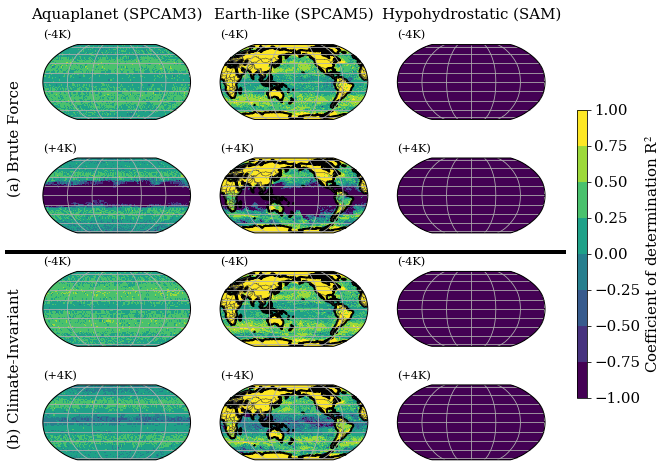

In [296]:
fig, ax = plt.subplots(4,3,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},figsize=(9,8))

for isub in range(12):
    ilin = int(np.floor(isub/3))
    icol = isub-3*ilin
    
    if ilin%2==0: 
        tit = '(-4K)'; 
        if icol==0: dataset = 'AQ-4K'; data = STaqua_m4K
        elif icol==1: dataset = 'RG-4K'; data = ST_m4K
    else: 
        tit = '(+4K)'
        if icol==0: dataset = 'AQ+4K'; data = STaqua_p4K
        elif icol==1: dataset = 'RG+4K'; data = ST_p4K
        
    if isub==0 or isub==3: toplot = R2_SH_geo[dataset]['2021_04_26_NN.hdf5']
    elif isub==1 or isub==4: toplot = R2_SH_geo[dataset]['2021_06_03_RG2AQ_NN.hdf5']
    elif isub==6 or isub==9: toplot = R2_SH_geo[dataset]['2021_04_26_NN_RH_TfromNS_LHF_nsDELQ.hdf5']
    elif isub==7 or isub==10: toplot =  R2_SH_geo[dataset]['2021_06_17_RG2AQ_NN_RH_BMSE_LHF_nsDELQ.hdf5']
    else: toplot = -toplot**0
    #print('isub = ',isub,'and mean R2 is ',np.mean(toplot.flatten()))
    imag = ax[ilin][icol].pcolormesh(data.lon, data.lat, 
                                     toplot,cmap=cmap_R2, norm=norm_R2,
                                     transform=ccrs.PlateCarree(),
                                     vmin=-1,vmax=1)
    ax[ilin][icol].gridlines()
    ax[ilin][icol].set_title(tit,loc='left',fontsize=3*fz/4)
    if icol==1:
            ax[ilin][icol].coastlines(linewidth=2.0,edgecolor='0.25')
            ax[ilin][icol].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

    # Colorbar
    if isub==0:
        cbar_ax = fig.add_axes(CBAR_position)
        CBAR = fig.colorbar(imag, label="Coefficient of determination R$^{2}$", cax=cbar_ax)
        cbar_ax.yaxis.set_ticks_position('right')
        cbar_ax.yaxis.set_label_position('right')

    # Title of each column
    if ilin==0:
        if isub==0: ax[0][isub].text(0.5,Y0,"Aquaplanet (SPCAM3)",fontsize=fz,
                                                   va='top',ha = 'center',
                                                   transform = ax[0][isub].transAxes)
        elif isub==1: ax[0][isub].text(0.5,Y0,"Earth-like (SPCAM5)",fontsize=fz,
                                                   va='top',ha = 'center',
                                                   transform = ax[0][isub].transAxes)
        elif isub==2: ax[0][isub].text(0.5,Y0,"Hypohydrostatic (SAM)",fontsize=fz,
                                                   va='top',ha = 'center',
                                                   transform = ax[0][isub].transAxes)
            
plt.draw()
# Horizontal line in the middle
ys = 0.5*(ax[1,0].get_position().y0+ax[2,0].get_position().y1)
line = plt.Line2D([0.07,0.93],[ys,ys], transform=fig.transFigure, color="black")
fig.add_artist(line)
# Vertical text to indicate subplots
plt.text(0.07,0.7,'(a) Brute Force',rotation=90,va='center',transform=fig.transFigure, color="black");
plt.text(0.07,0.3,'(b) Climate-Invariant',rotation=90,va='center',transform=fig.transFigure, color="black");

# Fourth row: PDF of bias correction & post/pre-processing